In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import zipfile
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [0]:
os.listdir('/content/drive/My Drive/DL')

['Gesture_Recog_CNN2D_GRU',
 'Gesture_Recog_CNN3D',
 'Gesture_Recog_CNN2D_LSTM',
 'Gesture_Recog_CNN2D_SimpleRNN',
 'WriteUp_Neural_Network_Gesture_Recognition_CaseStudy_Ver3.0.pdf',
 '.ipynb_checkpoints',
 'Hands-On-Image-Processing-with-Python-master',
 'train-scene classification']

In [0]:
"""with zipfile.ZipFile(os.path.join('/content/drive/My Drive/DL','train-scene classification.zip'),'r') as  zip_ref:
  zip_file = zip_ref.namelist()[0]
  zip_ref.extractall('/content/drive/My Drive/DL')"""

In [0]:
root = '/content/drive/My Drive/DL/train-scene classification/'
print (os.listdir(root))
print (len(os.listdir(root+'train')))

['train', 'train.csv']
24376


In [0]:
import pandas as pd
train = pd.read_csv(root+'/train.csv')
train.tail()

,image_name,label
17029,24325.jpg,4
17030,24328.jpg,3
17031,24329.jpg,3
17032,24332.jpg,5
17033,24334.jpg,2


In [0]:
NO_LABELS = len(set(train['label']))
NO_LABELS

6

In [0]:
#Actual Test Images
test = list(set(os.listdir(root+'train'))-(set(train['image_name'])))
trn  = list((set(train['image_name'])) - set(os.listdir(root+'train')))
print (len(test))
print (len(trn))

7342
0


In [0]:
train.label = train.label.astype('str')
train_chain = train.image_name+';'+train.label
train_chain[:5]

0    0.jpg;0
1    1.jpg;4
2    2.jpg;5
3    4.jpg;0
4    7.jpg;4
dtype: object

In [0]:
np.random.shuffle(train_chain)
train_data = train_chain[:13000]
test_data = train_chain[13000:]
print (len(train_data))
print (len(test_data))

13000
4034


In [0]:
train_aug = train_data.apply(lambda x: 'Aug;'+str(x))
train_fn = train_data.append(train_aug)
len(train_fn)

26000

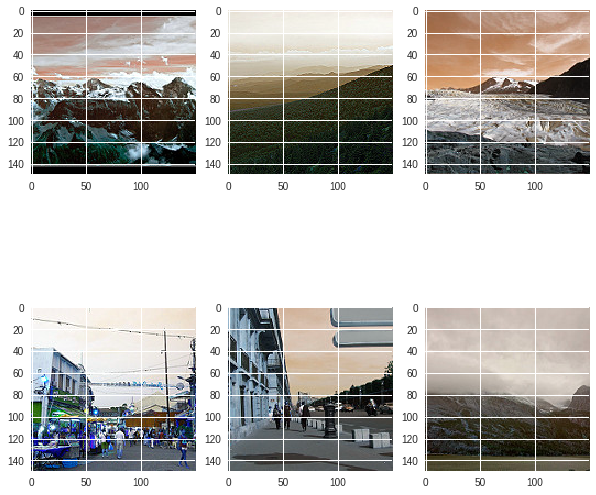

In [0]:
images = os.listdir(root+'train')
train_path = root+'train/'
idx = np.random.choice(images,size=6)
plt.figure(figsize=(10,10))
for i,x in enumerate(idx):
  plt.subplot(2,3,i+1)
  plt.imshow(cv2.imread(train_path+x))

In [0]:
def rotate(image,r):
  angle = random.uniform(-r,r)
  width,height = image.shape[:2]
  T = cv2.getRotationMatrix2D((width//2,height//2),angle,1)
  rot_img = cv2.warpAffine(image,T,(width,height))
  return rot_img

def translation(image,hor_shift=0,ver_shift=0):
  width,height = image.shape[:2]
  T = np.array([[1,0,hor_shift*width],[0,1,ver_shift*height]])
  trans = cv2.warpAffine(image,T,(width,height))
  return trans

def horizantal_flip(image):
  return image[:,::-1]

def vertical_flip(image):
  v = np.zeros(image.shape,np.uint8)
  v[:,:,0] = image[:,:,0].T
  v[:,:,1] = image[:,:,1].T
  v[:,:,2] = image[:,:,2].T
  return v
def noise_add(image):
  gauss = 50*np.random.normal(0,0.1,image.shape)
  gauss = gauss.astype('int').reshape(image.shape)
  return image+gauss
def zoom(image):
  width,height = image.shape[:2]
  a,b = width//4,height//4
  zoom = image[a:width-a,b:height-b]
  img = cv2.resize(zoom,(image.shape[:2]),interpolation = cv2.INTER_CUBIC)
  return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


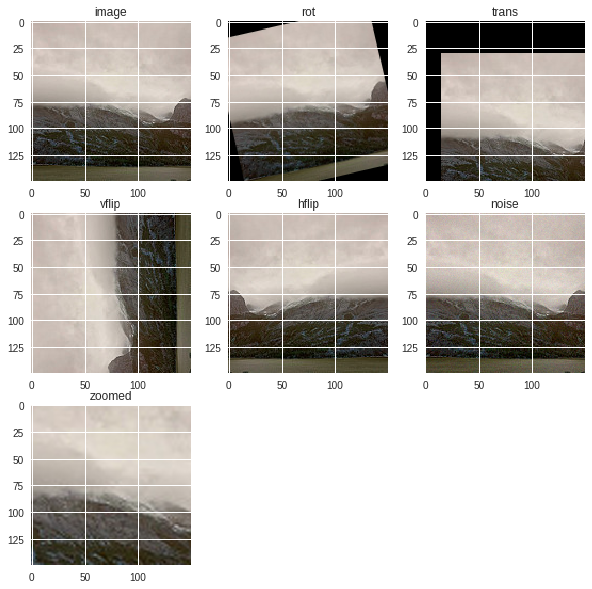

In [0]:
image = cv2.imread(train_path+x)
rot = rotate(image,30)
trans = translation(image,hor_shift= 0.1,ver_shift=0.2)
vflip = vertical_flip(image)
hflip = horizantal_flip(image)
noise = noise_add(image)
zoomed = zoom(image)
plt.figure(figsize=(10,10))
names = ['image','rot','trans','vflip','hflip','noise','zoomed']
for i,img in enumerate([image,rot,trans,vflip,hflip,noise,zoomed]):
  plt.subplot(3,3,i+1)
  plt.imshow(img)
  plt.title(names[i])

In [0]:
def Augmentation(image):
  aug = [translation(image,hor_shift= 0.15),rotate(image,30),translation(image,ver_shift=0.15),
         horizantal_flip(image),noise_add(image)]
  np.random.shuffle(aug)
  return aug[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


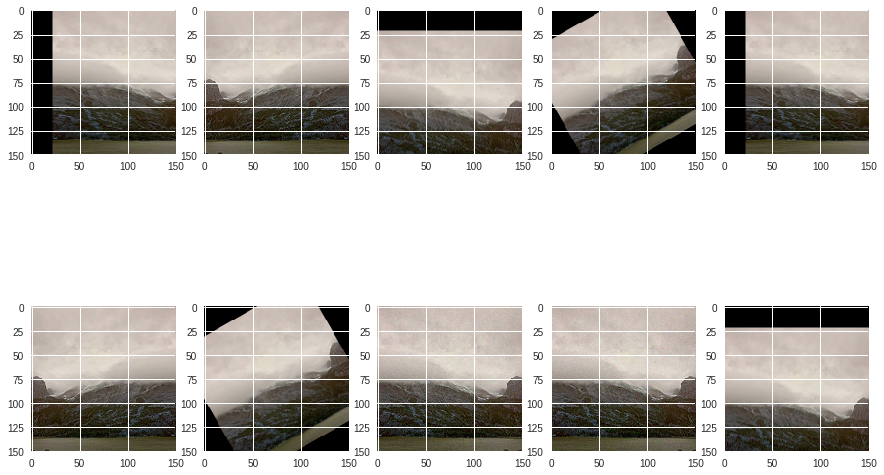

In [0]:
plt.figure(figsize=(15,10))
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(Augmentation(image))

In [0]:
PATH = train_path
SIZE = (128,128,3)
LABEL = 6
def Generator(train,bsize):
  N = len(train)
  steps = int(N//bsize)
  if N % bsize != 0:
    steps += 1
  while True:
    data = np.random.permutation(train)
    for batch in range(steps):
      batch_data = np.zeros((bsize,SIZE[0],SIZE[1],SIZE[2]))
      labels = np.zeros((bsize,LABEL))
      if (batch+1)*bsize <=N:
        chain = data[batch*bsize:(batch+1)*bsize]
      else:
        chain = data[batch*bsize:N-1]
      chain = data[batch*bsize:(batch+1)*bsize]
      for i,img in enumerate(chain):
        img_det = img.split(';')
        label = img_det[-1]
        name = img_det[-2]
        image = cv2.imread(PATH+name)
        if len(img_det) == 3:
          image = Augmentation(image)
        image = cv2.resize(image,(SIZE[0],SIZE[1]))
        batch_data[i,:,:,0] =  (image[:,:,0] - np.min(image[:,:,0]))/(np.max(image[:,:,0])-np.min(image[:,:,0]))  #normalise and feed in the image
        batch_data[i,:,:,1] =  (image[:,:,1] - np.min(image[:,:,1]))/(np.max(image[:,:,1])-np.min(image[:,:,1])) #normalise and feed in the image
        batch_data[i,:,:,2] =  (image[:,:,2] - np.min(image[:,:,2]))/(np.max(image[:,:,2])-np.min(image[:,:,2])) #normalise an
        labels[i,int(label)] = 1
      yield (batch_data,labels)
   

In [0]:
import tensorflow as tf
from keras import backend as K
from keras import Model
from keras import models
from keras import layers
from keras import optimizers
from keras import regularizers

Using TensorFlow backend.


In [0]:
model = models.Sequential()
model.add(layers.Conv2D(64,(5,5),input_shape = (SIZE),activation='relu',padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(LABEL,activation='softmax'))
model.compile(optimizer = optimizers.SGD(0.01),loss='categorical_crossentropy',metrics=['acc'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 64)      4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
batch_normalization_2

In [0]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
filepath =  'model-{epoch:05d}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)
callbacks_list = [checkpoint, LR]

In [0]:
BATCHSIZE = 32
EPOCHS = 5

train_steps_epoch = len(train_data)//BATCHSIZE
if len(train_fn)% BATCHSIZE != 0:
  train_steps_epoch += 1
test_steps_epoch = len(test_data)//BATCHSIZE
if len(test_data)% BATCHSIZE != 0:
  test_steps_epoch += 1
print (train_steps_epoch)
print (test_steps_epoch)

train_generator = Generator(train_data,BATCHSIZE)
test_generator = Generator(test_data,BATCHSIZE)
test_generator

407
127


<generator object Generator at 0x7f12bf438570>

In [0]:
model.fit_generator(train_generator, steps_per_epoch=train_steps_epoch, epochs=EPOCHS, verbose=1, 
                    validation_data=test_generator, callbacks = callbacks_list,
                    validation_steps=test_steps_epoch, class_weight=None, workers=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
407/407 [==============================] - 6629s 16s/step - loss: 0.9803 - acc: 0.6316 - val_loss: 2.5019 - val_acc: 0.4035

Epoch 00001: saving model to model-00001.h5
Epoch 2/5
407/407 [==============================] - 213s 524ms/step - loss: 0.7108 - acc: 0.7416 - val_loss: 1.5016 - val_acc: 0.5086

Epoch 00002: saving model to model-00002.h5
Epoch 3/5
407/407 [==============================] - 214s 526ms/step - loss: 0.6090 - acc: 0.7816 - val_loss: 1.4774 - val_acc: 0.5977

Epoch 00003: saving model to model-00003.h5
Epoch 4/5
407/407 [==============================] - 214s 525ms/step - loss: 0.6804 - acc: 0.7564 - val_loss: 4.7708 - val_acc: 0.3147

Epoch 00004: saving model to model-00004.h5
Epoch 5/5
407/407 [==============================] - 214s 525ms/step - loss: 0.6044 - acc: 0.7808 - val_loss: 3.5788 - val_acc: 0.3059

Epoch 00005: saving model to model-00005.h5


In [0]:
g_model = models.Sequential()
g_model.add(layers.Conv2D(64,(5,5),input_shape = (SIZE),activation='relu',padding='same'))
g_model.add(layers.BatchNormalization())
g_model.add(layers.MaxPooling2D((2,2)))
g_model.add(layers.Dropout(0.2))
g_model.add(layers.Conv2D(128,(3,3),activation='relu',padding='same'))
g_model.add(layers.BatchNormalization())
g_model.add(layers.MaxPooling2D((2,2)))
g_model.add(layers.Dropout(0.2))
g_model.add(layers.Conv2D(256,(3,3),activation='relu',padding='same'))
g_model.add(layers.BatchNormalization())
g_model.add(layers.GlobalAveragePooling2D())
g_model.add(layers.Dropout(0.2))
g_model.add(layers.Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
g_model.add(layers.BatchNormalization())
g_model.add(layers.Dropout(0.2))
g_model.add(layers.Dense(LABEL,activation='softmax',kernel_regularizer=regularizers.l2(0.01)))
g_model.compile(optimizer = optimizers.SGD(0.01),loss='categorical_crossentropy',metrics=['acc'])
g_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 128, 128, 64)      4864      
_________________________________________________________________
batch_normalization_17 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
batch_normalization_18 (Batc (None, 64, 64, 128)       512       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 128)       0         
__________

In [0]:
g_model.fit_generator(train_generator, steps_per_epoch=train_steps_epoch, epochs=EPOCHS, verbose=1, 
                    validation_data=test_generator, callbacks = callbacks_list,
                    validation_steps=test_steps_epoch, class_weight=None, workers=1)

Epoch 1/5
407/407 [==============================] - 221s 543ms/step - loss: 2.2124 - acc: 0.5451 - val_loss: 2.0724 - val_acc: 0.5273

Epoch 00001: saving model to model-00001.h5
Epoch 2/5
407/407 [==============================] - 215s 529ms/step - loss: 1.8021 - acc: 0.6493 - val_loss: 2.3227 - val_acc: 0.4141

Epoch 00002: saving model to model-00002.h5
Epoch 3/5
407/407 [==============================] - 217s 533ms/step - loss: 1.5608 - acc: 0.6996 - val_loss: 3.1666 - val_acc: 0.3410

Epoch 00003: saving model to model-00003.h5
Epoch 4/5
407/407 [==============================] - 217s 534ms/step - loss: 1.3839 - acc: 0.7207 - val_loss: 1.4436 - val_acc: 0.6690

Epoch 00004: saving model to model-00004.h5
Epoch 5/5
407/407 [==============================] - 215s 529ms/step - loss: 1.2210 - acc: 0.7491 - val_loss: 1.9136 - val_acc: 0.5177

Epoch 00005: saving model to model-00005.h5


In [0]:
from keras import applications

In [0]:
vgg = applications.VGG16(weights='imagenet',include_top = False,pooling='avg')

58892288/58889256 [==============================] - 3s 0us/step


In [0]:
for layer in vgg.layers:
  layer.trainable = False
vgg_model = models.Sequential()
vgg_model.add(layers.InputLayer(SIZE))
vgg_model.add(vgg)
vgg_model.add(layers.Dense(256,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
vgg_model.add(layers.Dropout(0.5))
vgg_model.add(layers.Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
vgg_model.add(layers.Dropout(0.5))
vgg_model.add(layers.Dense(LABEL,activation='softmax',kernel_regularizer = regularizers.l2(0.01)))
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 774       
Total params: 14,879,686
Trainable params: 164,998
Non-trainable params: 14,714,688
__________________________________________________________

In [0]:
vgg_model.compile(optimizer=optimizers.Adam(0.01),loss='categorical_crossentropy',metrics=['acc'])
filepath =  'modelvgg1-{epoch:05d}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)
callbacks_list = [checkpoint, LR]

In [0]:
vgg_model.fit_generator(train_generator, steps_per_epoch=train_steps_epoch, epochs=EPOCHS, verbose=1, 
                    validation_data=test_generator, callbacks = callbacks_list,
                    validation_steps=test_steps_epoch, class_weight=None, workers=1)

Epoch 1/5
407/407 [==============================] - 289s 711ms/step - loss: 13.6877 - acc: 0.1703 - val_loss: 13.5583 - val_acc: 0.1683

Epoch 00001: val_loss improved from inf to 13.55834, saving model to modelvgg1-00001.h5
Epoch 2/5
407/407 [==============================] - 276s 679ms/step - loss: 13.4428 - acc: 0.1731 - val_loss: 13.3073 - val_acc: 0.1713

Epoch 00002: val_loss improved from 13.55834 to 13.30728, saving model to modelvgg1-00002.h5
Epoch 3/5
407/407 [==============================] - 277s 680ms/step - loss: 13.3421 - acc: 0.1728 - val_loss: 13.3102 - val_acc: 0.1681

Epoch 00003: val_loss did not improve from 13.30728
Epoch 4/5
407/407 [==============================] - 279s 685ms/step - loss: 13.2151 - acc: 0.1790 - val_loss: 13.2365 - val_acc: 0.1718

Epoch 00004: val_loss improved from 13.30728 to 13.23654, saving model to modelvgg1-00004.h5
Epoch 5/5
407/407 [==============================] - 282s 693ms/step - loss: 13.3776 - acc: 0.1684 - val_loss: 13.3156 - v

In [0]:
fn_model = models.load_model('modelvgg1-00005.h5')
fn_model.compile(optimizer=optimizers.Adam(0.01),loss='categorical_crossentropy',metrics=['acc'])

In [0]:
sub = pd.read_csv('sample_submission.csv')
for image in sub.image_name:
  img = cv2.imread(PATH+image)
  img = cv2.resize(img,(SIZE[0],SIZE[1]))
  img = np.reshape(img,[1,SIZE[0],SIZE[1],3])
  lbl = fn_model.predict_classes(img)
  sub['label_1'] = lbl[0]
sub.head()

,image_name,label,label_1
0,3.jpg,0,0
1,5.jpg,0,0
2,6.jpg,0,0
3,11.jpg,0,0
4,14.jpg,0,0


In [0]:
label_fn = [ x[0] for x in predicted]
final_df = pd.DataFrame({})
final_df['image'] = test
final_df['label'] = label_fn
final_df.head()

,image_name,label
0,3.jpg,0
1,5.jpg,0
2,6.jpg,0
3,11.jpg,0
4,14.jpg,0
5,22.jpg,0
6,25.jpg,0
7,28.jpg,0
8,30.jpg,0
9,38.jpg,0


In [0]:
final_df.to_csv('out.csv',index=False)

In [0]:
sub.head(50)

In [0]:
for i,img in enumerate(train_fn):
        if len(img.split(';')) == 3:
          _,name,label = img.split(';')
          print  (name,label)

In [0]:
Gen(train_fn,32)

12477.jpg;3
22970.jpg;5
13791.jpg;5
2699.jpg;1
Aug;14379.jpg;3
22025.jpg;0
16375.jpg;3
Aug;3067.jpg;0
352.jpg;1
521.jpg;1
Aug;16887.jpg;2
Aug;16716.jpg;2
Aug;14865.jpg;4
Aug;2754.jpg;5
Aug;3475.jpg;5
4039.jpg;2
13219.jpg;3
Aug;5088.jpg;1
Aug;14628.jpg;5
13763.jpg;5
12393.jpg;0
Aug;22467.jpg;4
Aug;18224.jpg;3


error: ignored